In [14]:
!pip install tensorflow==1.14

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

np.random.seed(42)
tf.set_random_seed(42)

%matplotlib inline

In [16]:
mnist = input_data.read_data_sets('MNIST_data')
input_size = 28 * 28
num_digits = 10

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [17]:
params = {
    'encoder_layers': [128],                
    'decoder_layers': [128],                
    'digit_classification_layers': [128],   # for conditions
    'activation': tf.nn.sigmoid,            
    'decoder_std': 0.5,                     # std for P(x|z) 
    'z_dim': 10,                            # latent space dimension
    'digit_classification_weight': 10.0,    # for conditions
    'epochs': 25,
    'batch_size': 100,
    'learning_rate': 0.001
}

In [18]:
images = tf.placeholder(tf.float32, [None, input_size])
digits = tf.placeholder(tf.int32, [None])

# encode the image into latent space
encoder_mu, encoder_var = encoder(images,
                                  params['encoder_layers'])

# sample the vector from latent space, using
# reparametrization
eps = tf.random_normal(shape=[tf.shape(images)[0],
                              params['z_dim']],
                       mean=0.0,
                       stddev=1.0)
z = encoder_mu + tf.sqrt(encoder_var) * eps

# classify the digit
digit_logits = digit_classifier(images,
                                params['digit_classification_layers'])
digit_prob = tf.nn.softmax(digit_logits)

# decode latent vector using digit classification condition into the image
decoded_images = decoder(tf.concat([z, digit_prob], axis=1),
                         params['decoder_layers'])

In [19]:
def encoder(x, layers):
    for layer in layers:
        x = tf.layers.dense(x,
                            layer,
                            activation=params['activation'])
    mu = tf.layers.dense(x, params['z_dim'])
    var = 1e-5 + tf.exp(tf.layers.dense(x, params['z_dim']))
    return mu, var


def decoder(z, layers):
    for layer in layers:
        z = tf.layers.dense(z,
                            layer,
                            activation=params['activation'])
    mu = tf.layers.dense(z, input_size)
    return tf.nn.sigmoid(mu)


def digit_classifier(x, layers):
    for layer in layers:
        x = tf.layers.dense(x,
                            layer,
                            activation=params['activation'])
    logits = tf.layers.dense(x, num_digits)
    return logits


# loss for reconstructed image
loss_reconstruction = -tf.reduce_sum(
    tf.contrib.distributions.Normal(
        decoded_images,
        params['decoder_std']
    ).log_prob(images),
    axis=1
)

# loss for the current hidden space distribution parameters
loss_prior = -0.5 * tf.reduce_sum(
    1 + tf.log(encoder_var) - encoder_mu ** 2 - encoder_var,
    axis=1
)

# autoencoder loss
loss_auto_encode = tf.reduce_mean(
    loss_reconstruction + loss_prior,
    axis=0
)

# loss for digit_classification
loss_digit_classifier = params['digit_classification_weight'] * tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=digits,
                                                   logits=digit_logits),
    axis=0
)

# final loss
loss = loss_auto_encode + loss_digit_classifier

train_op = tf.train.AdamOptimizer(params['learning_rate']).minimize(loss)

In [20]:
# Training

samples = []
losses_auto_encode = []
losses_digit_classifier = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(params['epochs']):
        print("Epoch # - ",epoch)
        for _ in range(mnist.train.num_examples // params['batch_size']):
            batch_images, batch_digits = mnist.train.next_batch(params['batch_size'])
            sess.run(train_op, feed_dict={images: batch_images, digits: batch_digits})
        
        train_loss_auto_encode, train_loss_digit_classifier = sess.run(
            [loss_auto_encode, loss_digit_classifier],
            {images: mnist.train.images, digits: mnist.train.labels})
        
        losses_auto_encode.append(train_loss_auto_encode)
        losses_digit_classifier.append(train_loss_digit_classifier)
        
        sample_z = np.tile(np.random.randn(1, params['z_dim']), reps=[num_digits, 1])
        gen_samples = sess.run(decoded_images,
                               feed_dict={z: sample_z, digit_prob: np.eye(num_digits)})
        samples.append(gen_samples)

print("\nTraining completed!")


Epoch # -  0
Epoch # -  1
Epoch # -  2
Epoch # -  3
Epoch # -  4
Epoch # -  5
Epoch # -  6
Epoch # -  7
Epoch # -  8
Epoch # -  9
Epoch # -  10
Epoch # -  11
Epoch # -  12
Epoch # -  13
Epoch # -  14
Epoch # -  15
Epoch # -  16
Epoch # -  17
Epoch # -  18
Epoch # -  19
Epoch # -  20
Epoch # -  21
Epoch # -  22
Epoch # -  23
Epoch # -  24

Training completed!


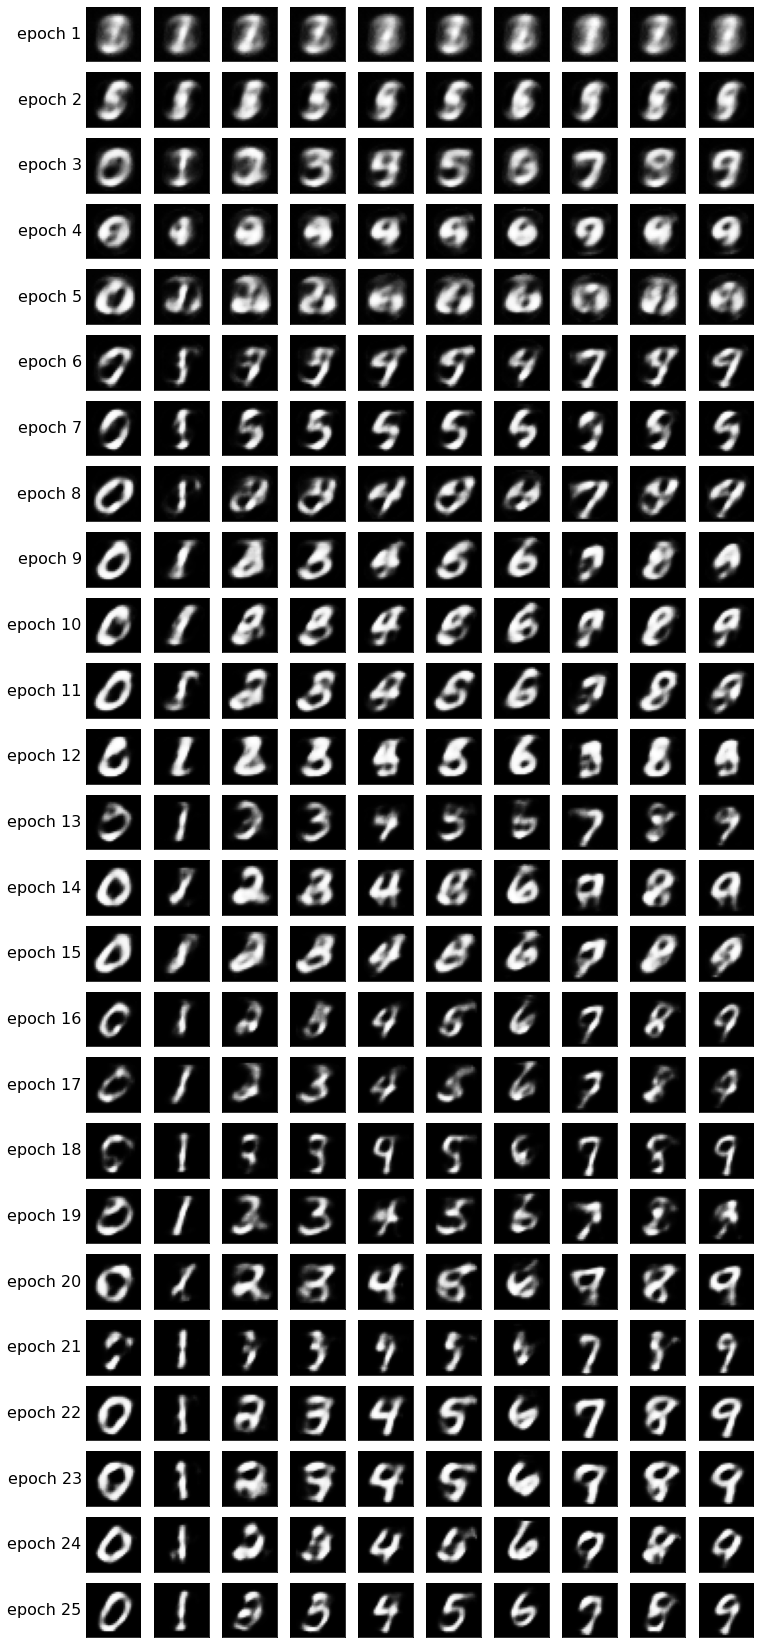

In [21]:
def plot_samples(samples):
    IMAGE_WIDTH = 1.2
    plt.figure(figsize=(IMAGE_WIDTH * num_digits,
                        len(samples) * IMAGE_WIDTH))
    for epoch, images in enumerate(samples):
        for digit, image in enumerate(images):
            plt.subplot(len(samples),
                        num_digits,
                        epoch * num_digits + digit + 1)
            plt.imshow(image.reshape((28, 28)),
                       cmap='Greys_r')
            plt.gca().xaxis.set_visible(False)
            if digit == 0:
                plt.gca().yaxis.set_ticks([])
                plt.ylabel('epoch {}'.format(epoch + 1),
                           verticalalignment='center',
                           horizontalalignment='right',
                           rotation=0,
                           fontsize=16)
            else:
                plt.gca().yaxis.set_visible(False)
                
                
plot_samples(samples)